<a href="https://colab.research.google.com/github/rummanrc/sentimentmoviebn/blob/master/BanglaSentiAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1tfn-KQzzWfkEsb7dmHYy6hhTzsbgg8tu'})
download.GetContentFile('revFakeCSVnew.csv')
download = drive.CreateFile({'id': '1-RINuYwFtXy1DdUGZ3WnIexcXfgXlS_s'})
download.GetContentFile('stopwords-bn.txt')
#https://drive.google.com/open?id=1tfn-KQzzWfkEsb7dmHYy6hhTzsbgg8tu
#https://drive.google.com/open?id=1-RINuYwFtXy1DdUGZ3WnIexcXfgXlS_s

In [0]:
import re

import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
plt.style.use('ggplot')


roots=[];
dicbased=[];
rulebased=[];


uposorgoStrings=["অ","অঘা","অজ","অনা","আ","আড়","আন","আব","ইতি","ঊন","ঊনা","কদ","কু","নি","পাতি","বি","ভর","রাম","স","সা","সু","হা ",
		"প্র","পরা","অপ","সম","নি","অনু","অব","নির","দুর","বি","অধি","সু","উৎ","পরি","প্রতি","অতি","অপি","অভি","উপ","আ",
		"কার","দর","নিম","ফি","বদ","বে","বর","ব","কম","আম","খাস","লা","গর","ফুল","হাফ","হেড","সাব","হর"];



prottoi=["মুক্ত","গামী","গামীর","চারী","চারীর","বাহী","বাহীর","সমেত","মণ্ডলী","মণ্ডলীর",
	"কর্মা","কর্মার","কার্য","পূর্ব","কর","করা","করার","মালা","মালার","কীর্তি","কীর্তির","করণ","াংশ","গত","জনক","কণা","কণার","সহ",
	"মূলক","ভাবে","যোগ্য","ভিত্তিক","সূচক","কারী","কারীর","প্রবণ","প্রবণতা","প্রবণতার","সুলভ","পূর্ণ","তে","তা","কালীন","মত","ত্ব","পত্র",
	"মুখী","মুখীর","সম্পন্ন","ময়","সংক্রান্ত","সমৃদ্ধ","দার","ভরা","ভরার","গ্রস্ত","জনিত","জীবী","জীবীর","নীতি","নীতির","বিধি","বিধির","বাজ","বিমুখ",
	"শীল","বাদী","বাদীর","বান","গাছি","গাছির","নামা","নামার","জন","বহ","বার","ধারী","ধারীর","দায়ক","দাতা","দাতার","কাল","সূচি","সূচির","গার","ভোগী","ভোগীর", "ভাগী","ভাগীর", 
	"মাত্র","বিদ","বাদ","কণা","ভক্ত","ভুক্ত","ভুক্তি","ভুক্তির","ভুক্তিতে","পন্থা","পন্থী","পন্থীর","কামী","কামীর","যোগ","যোগে","বোধ","প্রতি",
	"কাজ","তম","বিষয়ক","সামগ্রী","সামগ্রীর","জাত","বাজি","বাজির","কবলিত","সূত্রে","জাত","বদ্ধ",
	"টা","টি","টু","টির","টার","টুকু","টুকুর","ধর্মী","ধর্মীর","যুক্ত","কৃত","ব্যাপী","ব্যাপীর","কেন্দ্রিক","বিরোধী","বিরোধীর","মুক্তি","মুক্তির",
	"রূপী","রূপীর","রূপে","রূপ","শালি","শালির","শালী","শালীর","প্রসূত","বাসী","বাসীর","প্রবাসী","প্রবাসীর","প্রাপ্ত","গোষ্ঠী","গোষ্ঠীর","বাচক","নির্ভর","স্বর",
	"সংলগ্ন","শাস্ত্র","মাফিক","স্বরূপ","কূল","সম্মত","সিদ্ধ","বৃন্দ","দান","সহ","বশত","ভর", 
	#i
	"ই","ও","এর","এ",
	#prottoi
	"য়ে","না","তি","তা","ওয়া","উয়া","উনি","উকা","ঈ","আও","অ"," রি"," তি"," তা","তে", " এ"," ঊ",
	" উরি"," উন্তি"," উক"," ইয়ে"," ইয়া"," ইলে"," আল",
	" আরী"," আরি"," আনো"," আনি"," আন"," আত"," আকু"," আইত"," আই"," আ"," অন্তি"," অন্ত"," অনি",
	" অনা"," অন"," অতি"," অতা"," অত"," অক",
	" োয়া","ুয়া","ুন্তি","ুনি","ুকা","ুকা","ু","ো","ে","ী","ীয়",
         #/*"ি",*/
         "য়",
	# prottoi-bangla(toddit)
	"ড়ে","ড়ি","ড়া","সে","সিয়","সা","লা","মি","মন্ত","ভরা","ভর","পারা","পানো","পনা","নি","তুত","তি","তা",
	"টে","টিয়া","টা","চে","কে","কিয়া","কা","ক","ওয়ালা","এল","এল","ঊ","উয়া","উড়িয়া","উড়","উলি","উরে",
	"উরিয়া","উক","ইয়াল","ইয়া","ই","আলো","আলি","আলা","আল","আরু","আরি","আর","আমো","আমি","আম",
	"আনো","আনি","আত","আচি","আচ","আইত","আই","আ","অড়","অল",
	#case
	"ের","য়েদেরকে","েদেরকে","দেরকে","য়েদের","েদের","য়েরা","ভাবে","দের","েরা","োর","ার","য়ের",
	#/*"কায়",*/
        "কার","িলা","িলা","িত","ান","কু","কা","তে","রা","য়","মি",
        #/*"সি","ড়ে",*/
        "কে","েই","র","া","ানু","বৃন্দ",
        #"য়","ব","ম","স",
	#article 
	"খানা","খানার","খানায়","খানি","খানির","গুলো","গুলো","গুলোর","গুলোয়","গুলোতে","গুলি","গুলির","গুলিতে","য়োন","খান","গুল","সমূহ","গণ",
	"টা","টি","টু","টির","টার","টুকু",
	"কা","তা","িল","িক",	"েক","েত",
        #/*"লি",*/
        "য়া","ায়","ড়ি","িস","ান",
	"হীনতা","হীন","বিহীন",
	#verb
	"ছিস", "ছে", "ছেন", "চ্ছি", "চ্ছ", "চ্ছে","চ্ছেন", 
	"েছি","েছ","েছে","েছেন",
	"াছি","াছ","াছে","াছেন",
	"িয়","ি",			
	"য়াছ","য়াছি","য়াছে","য়াছেন",
	"লাম","লেম","লুম","লেন", "ছিলে", "ছিল", "তো", 
	"তাম","তেম","তুম", "তেন", "ল",
	"বেন", "বো","বে","বি", "েন",
	"াম","েম","ুম",
	"িয়ে",
	"াই", 
	#normalization
	"িনি","নি","না","তেই","টাই","স্থ","ায়ন","াচ্ছন্ন",#/*"ক",*/
        "তে" #//normalize
        ];


must=["ই","ও","এর","এ","ের","য়েদেরকে","েদেরকে","দেরকে","য়েদের","েদের","য়েরা","ভাবে","দের","েরা","য়ের","রা","কে",
     "খানা","খানার","খানায়","খানি","খানির","গুলো","গুলো","গুলোর","গুলোয়","গুলোতে","গুলি","গুলির","গুলিতে","য়োন","খান","গুল",
     "সমূহ","গণ", 
     "মুক্ত","গামী","গামীর","চারী","চারীর","বাহী","বাহীর","সমেত","মণ্ডলী","মণ্ডলীর",
     "কর্মা","কর্মার","কার্য","পূর্ব","কর","করা","করার","মালা","মালার","কীর্তি","কীর্তির","করণ","াংশ","গত","জনক","কণা","কণার","সহ",
     "মূলক","ভাবে","যোগ্য","ভিত্তিক","সূচক","কারী","কারীর","প্রবণ","প্রবণতা","প্রবণতার","সুলভ","পূর্ণ","তে","তা","কালীন","মত","ত্ব","পত্র",
     "মুখী","মুখীর","সম্পন্ন","ময়","সংক্রান্ত","সমৃদ্ধ","দার","ভরা","ভরার","গ্রস্ত","জনিত","জীবী","জীবীর","নীতি","নীতির","বিধি","বিধির","বাজ","বিমুখ",
     "শীল","বাদী","বাদীর","বান","গাছি","গাছির","নামা","নামার","জন","বহ","বার","ধারী","ধারীর","দায়ক","দাতা","দাতার","কাল","সূচি","সূচির","গার","ভোগী","ভোগীর", "ভাগী","ভাগীর", 
     "মাত্র","বিদ","বাদ","কণা","ভক্ত","ভুক্ত","ভুক্তি","ভুক্তির","ভুক্তিতে","পন্থা","পন্থী","পন্থীর","কামী","কামীর","যোগ","যোগে","বোধ","প্রতি",
     "কাজ","তম","বিষয়ক","সামগ্রী","সামগ্রীর","জাত","বাজি","বাজির","কবলিত","সূত্রে","জাত","বদ্ধ",
     "টা","টি","টু","টির","টার","টায়","টুকু","টুকুর","ধর্মী","ধর্মীর","যুক্ত","কৃত","ব্যাপী","ব্যাপীর","কেন্দ্রিক","বিরোধী","বিরোধীর","মুক্তি","মুক্তির",
     "রূপী","রূপীর","রূপে","রূপ","শালি","শালির","শালী","শালীর","প্রসূত","বাসী","বাসীর","প্রবাসী","প্রবাসীর","প্রাপ্ত","গোষ্ঠী","গোষ্ঠীর","বাচক","নির্ভর","স্বর",
     "সংলগ্ন","শাস্ত্র","মাফিক","স্বরূপ","কূল","সম্মত","সিদ্ধ","বৃন্দ","দান","বশত","ভর",
     "সহ","ে","ের","েয়","ীয়","েক","িক","িতা","িণী","িনী","ী" ];
      
def stemmer( text ):
    WORD_PATTERN=" +|-|'|\b|\t|\n|\f|\r|\"|\'|#|%|&|~|@|<|>|\*|\+|\=|\.|,|\।৷|'|\)|\(|\{|\}|\[|\]|;|:|/|\\\\|-|_|—|–|”|“";
    st=re.split(WORD_PATTERN,text);
    stemWordList=[];
    roots.clear();
    roots.append(text);
    for str in st :
        if len(str)>0:
            dicbased.clear();
            rulebased.clear();
            stem = findStem(str);
            stemWordList.append(stem);
            print(stem," =>");
            print(dicbased);
            print(rulebased);


def findStem( word ):
    rootminstem="";
    dicbased.clear();
    temp="";
    rootminlen = 1000;
    dicbased.append(word);
    rightTrim(word);

    for i in range(0,len(dicbased)):
        temp=dicbased[i];
        length=len(temp);
        if temp not in roots:
            continue;
        if(length>=2 and length<rootminlen):
            rootminstem=temp;
            rootminlen=length;
    if len(rootminstem)>0:
        return rootminstem;
    rulebased.clear();
    rulebased.append(word);
    rightTrimMust(word);

    for i in range(0,len(rulebased)):
        temp=rulebased[i];
        length=len(temp);
        if length>=2 and length<rootminlen:
            rootminstem=temp;
            rootminlen=length;
    return rightTrimRa(rootminstem);
    
    

def rightTrim(word):
    if len(word)<3 :
        return;
    fraction=word;
    for str  in prottoi:
        if(word.endswith(str)):
            fraction = word[0:len(word)-len(str)];
            if(len(fraction)<2):
                continue;
            a="্";#0x09CD
            ch=fraction[len(fraction)-1];
            if ch==a:
                continue;
            if (len(word) != len(fraction)):
                dicbased.append(fraction);
                rightTrim(fraction);
    return;

def rightTrimMust( word ):
    if len(word)<3:
        return;
    fraction="";
    if word.endswith("য়") and word.endswith("ায়"):
        word=word[0:len(word)-1];
        rulebased.append(word);

    for i in range(0,len(must)):
        if word.endswith(must[i]):
            fraction=word[0:len(word)-len(must[i])];
            if len(fraction)<2:
                continue;
            a="্";#0x09CD
            ch=fraction[len(fraction)-1];
            if ch==a:
                continue;
            if len(word)!=len(fraction):
                rulebased.append(fraction);
                rightTrimMust(fraction);


def rightTrimRa(word):
    if len(word)<3:
        return word;
    fraction=word;
    if word.endswith("র"):
        if word.endswith("পুর"):
            return fraction;
        a="্"#0x09CD
        b="া"#0x09BE
        c="ৗ"#0x09D7
        ch=word[len(word)-2];
        if ch>=b and ch<=c and ch!=a:
            fraction=word[0:len(word)-1];
    return fraction;



def read_corpus( use_sentiment):
    documents = []
    labels = []
    #waste = '''’'()[]{}<>:,‒–—―….«»-‐‘’“”;/⁄␠·&@*\\•^¤¢$€£¥₩₪†‡°¡¿¬#№%‰‱¶′§~¨_|¦⁂☞∴‽※'"-\।()/'\"%#/@;:<>{}+=~|—‘’“”\.,`$^&*_'''
    waste = '''
    ’'()[]♥{}<>:,‒–—―….«»-‐‘’“”;/⁄␠·&@*\\•^¤¢$€£¥₩₪†‡°¡¿¬#№%‰‱¶′§~¨_|¦⁂☞∴‽※'"-\।()/'\"%#/@;:<>{}+=~|—‘’“”\.!?,`$^&*_
    +=abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789০১২৩৪৫৬৭৮৯🙂😀😄😆😅😂🤣😊☺️😌😉😏😍😘😗😙😚🤗😳🙃😇
    😈😛😝😜😋🤤🤓😎🤑😒🙁☹️😞😔😖😓😢😢😭😟😣😩😫😕🤔🙄😤😠😡😶🤐😐😑😯😲😧😨😰😱😪😴😬🤥🤧🤒😷🤕😵
    🤢🤠🤡👿👹👺👻💀👽👾🤖💩🎃⚔👹\🐡🐟🐠🙂😀😂👍😐😡🏽✊☝🙌👍🏻👎🏻✌️🏻🤞🏻👌🏻🤙🏻🤘🏻🖕🏻☝️🏻💅🏻👉🏻👈🏻👇🏻👆🏻💚💙❤💔💕💜💓💞💗💘💖💝💟
    '''

    '''
    data=pd.read_excel("E:/8th semester/thesis/from hanif sir/New folder/old_combined_uq.xlsx")
    for line in data.status_text:
        tokens = line.strip().split()
        temp = []
        for char in tokens:
            no_punct = findStem(char)
            temp.append(no_punct)
        documents.append(temp)
    if use_sentiment:
            # 2-class problem: positive vs negative
        for line in data.label:
            
            labels.append(line)
    return documents, labels
    '''
    corpus_file="revFakeCSVnew.csv"
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            tokens = line.strip().split()
            temp = []
            if (tokens[0]=='pos' or tokens[0]=='neg'):
                for char in tokens[1:]:
                    no_punct = ""
                    for ch in char:
                        if ch not in waste:
                            no_punct = no_punct + ch
                    if no_punct:
                        no_punct = findStem(char)
                        if no_punct:
                            temp.append(no_punct)
                documents.append(temp)
                if use_sentiment:
                    # 2-class problem: positive vs negative
                    #for line in data.label:
                    #print(tokens[0], end=" ")
                    #if (tokens[0]=='pos' or tokens[0]=='neg'):
                    labels.append(tokens[0])
    return documents, labels
    

def read_stopwords(stopwords_file):
    stop_words = []
    with open(stopwords_file, encoding='utf-8-sig') as f:
        for line in f:
            stop_words.append(line.strip())

    return stop_words

def remove_stopwords(word_list, stopwords_list):
    processed_word_list = []

    for doc in word_list:
        temp = []
        for word in doc:
            if word not in stopwords_list:
                temp.append(word)

        processed_word_list.append(temp)

    return processed_word_list


In [0]:
from keras import optimizers
DOC, LBL = read_corpus(1);

stop_words = read_stopwords('stopwords-bn.txt')
DOC = remove_stopwords(DOC, stop_words)

data = pd.DataFrame(
    {'status_text': DOC,
     'label': LBL
    })

data['target'] = data.label.astype('category').cat.codes
#data['num_words'] = data.status_text.apply(lambda x : len(x.split()))

num_class = len(np.unique(data.label.values))
y = data['target'].values

MAX_LENGTH = 20
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.status_text.values)
post_seq = tokenizer.texts_to_sequences(data.status_text.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.20)

vocab_size = len(tokenizer.word_index) + 1

print(vocab_size)


inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size,
                            256,
                            input_length=MAX_LENGTH)(inputs)

x = LSTM(128)(embedding_layer)
#x = Dense(128)(embedding_layer)
#x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
#sgd = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()

filepath="weights.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlyStopping = EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='max')
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_data=(X_test,to_categorical(y_test)),
                    shuffle=True, epochs=400, callbacks=[checkpointer,earlyStopping])

df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='blue')

model.load_weights('weights.hdf5')
predicted = model.predict(X_test)
print("predicted  = ")
#print(predicted)
#matrix = metrics.confusion_matrix(X_test.argmax(axis=1), predicted.argmax(axis=1))
#print(matrix);
predicted = np.argmax(predicted, axis=1)

print(confusion_matrix(y_test, predicted))

print(accuracy_score(y_test, predicted))

In [0]:
print(post_seq[29])
print(post_seq_padded[29])
print(tokenizer.word_index)

[164, 140, 444, 1, 56, 8, 2007, 3, 200, 770]
[   0    0    0    0    0    0    0    0    0    0  164  140  444    1
   56    8 2007    3  200  770]
{'মুভি': 1, 'এক': 2, 'কর': 3, 'দেখ': 4, 'আমা': 5, 'ভালো': 6, 'অন': 7, 'মন': 8, 'সিনেমা': 9, 'থে': 10, 'অভিনয়': 11, 'ভাল': 12, 'গল্প': 13, 'নিয়': 14, 'ছবি': 15, 'শেষ': 16, 'সাথ': 17, 'না।': 18, 'বল': 19, 'কথা': 20, 'সময়': 21, 'টা': 22, 'সিরিজ': 23, 'পা': 24, 'মত': 25, 'তব': 26, 'চরিত্র': 27, 'আপনা': 28, 'মধ্য': 29, 'দিয়': 30, 'আগ': 31, 'নাটক': 32, 'আছ': 33, 'সুন্দর': 34, 'নিজ': 35, 'চলচ্চিত্র': 36, 'হব': 37, 'মানুষ': 38, 'আসল': 39, 'হয়েছ': 40, 'অসাধারণ': 41, 'নাম': 42, 'সবা': 43, 'আরো': 44, 'দি': 45, 'হিসেব': 46, 'কাহ': 47, 'মুভি।': 48, 'রিভিউ': 49, 'কম': 50, 'সবচ': 51, 'সাল': 52, 'বছর': 53, 'ফিল্ম': 54, 'হওয়া': 55, 'সত্যি': 56, 'আশা': 57, 'পুরো': 58, 'লাগ': 59, 'ছিল।': 60, 'ছিলো': 61, 'জীবন': 62, 'পরিচালক': 63, 'গুলো': 64, 'এতো': 65, 'থ্রিলা': 66, 'দেখল': 67, 'পছন্দ': 68, 'হচ্ছ': 69, 'দৃশ্য': 70, 'ফ্লপ': 71, 'দর্শক': 72, 'অভিন': 73, 'মাথা':

13285
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 20)                0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 20, 256)           3400960   
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_33 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 130       
Total params: 3,606,466
Trainable params: 3,606,466
Non-trainable params: 0
_________________________________________________________________
Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 6s 2ms/step - loss: 0.6

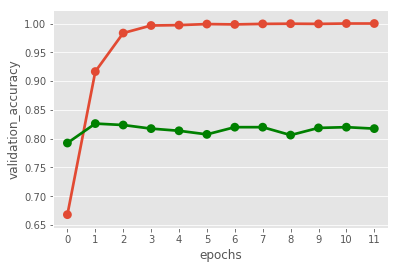

In [0]:
DOC, LBL = read_corpus(1);

stop_words = read_stopwords('stopwords-bn.txt')
DOC = remove_stopwords(DOC, stop_words)

data = pd.DataFrame(
    {'status_text': DOC,
     'label': LBL
    })

data['target'] = data.label.astype('category').cat.codes
#data['num_words'] = data.status_text.apply(lambda x : len(x.split()))

num_class = len(np.unique(data.label.values))
y = data['target'].values

MAX_LENGTH = 20
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.status_text.values)
post_seq = tokenizer.texts_to_sequences(data.status_text.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.20)

vocab_size = len(tokenizer.word_index) + 1

print(vocab_size)


inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size,
                            256,
                            input_length=MAX_LENGTH)(inputs)

x = LSTM(128)(embedding_layer)
x = Dense(64, activation='relu')(x)
#x = Dense(128, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()

filepath="weights.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlyStopping = EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='max')
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_data=(X_test,to_categorical(y_test)),
                    shuffle=True, epochs=50, callbacks=[checkpointer,earlyStopping])

df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')

model.load_weights('weights.hdf5')
predicted = model.predict(X_test)
print("predicted  = ")
#print(predicted)
#matrix = metrics.confusion_matrix(X_test.argmax(axis=1), predicted.argmax(axis=1))
#print(matrix);
predicted = np.argmax(predicted, axis=1)

print(confusion_matrix(y_test, predicted))

print(accuracy_score(y_test, predicted))